# Yale Hydropower Model

## Rocky River Powerplant

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime, calendar
import random

In [86]:
# Load data
stream_flow_data_path = './data/StreamFlowData.csv'
stream_flow_df = pd.read_csv(stream_flow_data_path)
stream_flow_df = stream_flow_df.drop(['Unnamed: 0', 'agency_cd', 'site_no', 'X_00060_00003_cd'], axis=1)
stream_flow_df = stream_flow_df.rename(columns={"Date":"Date", "X_00060_00003":"CFS"})
stream_flow_df['Date'] = pd.to_datetime(stream_flow_df['Date'], format='%m/%d/%Y')
# filter out 1993-2021
df_stream = stream_flow_df[(stream_flow_df['Date'] >= '1993-01-01') & (stream_flow_df['Date'] < '2022-01-01')]
df_stream = df_stream[~((df_stream.Date.dt.month == 2) & (df_stream.Date.dt.day == 29))]

In [87]:
# df_stream = df_stream.set_index('Date')
CFS = list(df_stream['CFS'])
Dates = list(df_stream['Date'])

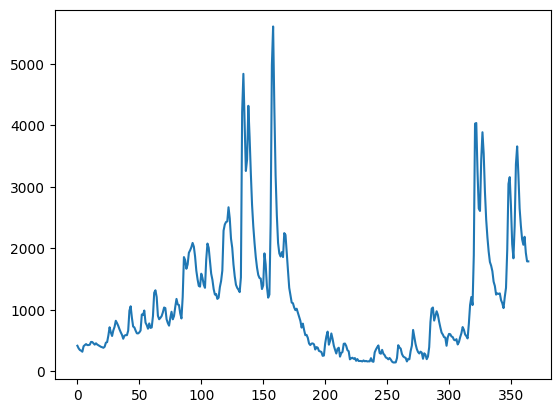

In [153]:
x_temp = np.arange(0, 365, 1)
year_offset = 9
plt.plot(x_temp, CFS[365 * year_offset:365 + 365 * year_offset])

In [89]:
def find_minima(s):
    n = len(s)
    minima_loc = [0]
    for i in range(1, n - 1):
        if s[i] <= s[i - 1] and s[i] <= s[i + 1]:
            minima_loc.append(i)
    minima_loc.append(n-1)
    return minima_loc

def interpolate_minima(s, minima):
    new_s = []
    for i in range(len(minima) - 1):
        diff = s[minima[i + 1]] - s[minima[i]]
        interval = diff / (minima[i + 1] - minima[i])
        for j in range(minima[i + 1] - minima[i]):
            new_s.append(s[minima[i]] + j * interval)
    new_s.append(s[-1])
    return new_s

In [90]:
CFS_minima = find_minima(CFS)
CFS_interpolated = interpolate_minima(CFS, CFS_minima)
CFS_years = []
CFS_interpolated_years = []
CFS_net_years = []
counter = 0
base_year = 1993
year_nums = []
for i in range(int(len(CFS) / 365)):
    year = []
    year_interp = []
    net_flow = 0
    for j in range(365):
        year.append(CFS[counter])
        year_interp.append(CFS_interpolated[counter])
        net_flow += CFS[counter]
        counter += 1
    CFS_years.append(year)
    CFS_interpolated_years.append(year_interp)
    CFS_net_years.append(net_flow)
    year_nums.append(base_year + i)

In [91]:
sf_data = []
for i, y in enumerate(year_nums):
    sf_data.append((y, CFS_net_years[i], CFS_years[i], CFS_interpolated_years[i]))
sorted_data = sorted(sf_data, key=lambda x: x[1], reverse=True)

In [92]:
print(len(sorted_data))
Q1 = []
Q4 = []
for i in range(8):
    Q1.append(sorted_data[-(i + 1)])
    Q4.append(sorted_data[i])

print("Q1")
for i in range(8):
    print(Q1[i][0], Q1[i][1])

print("Q4")
for i in range(8):
    print(Q4[i][0], Q4[i][1])

29
Q1
2016 373789.0
2002 411245.0
2012 476177.0
2015 498124.0
2001 502345.0
1995 519831.0
2020 522484.0
2017 526530.0
Q4
2011 1122488.0
1996 1037640.0
2018 989207.0
2008 953990.0
2021 874727.0
2003 870683.0
2005 853226.0
2006 841289.0


In [93]:
Q1_ave_baseflow = []
Q1_min_baseflow = []
Q1_max_baseflow = []
Q4_ave_baseflow = []
Q4_min_baseflow = []
Q4_max_baseflow = []

for d in range(365):
    Q1_ave = 0.0
    Q4_ave = 0.0
    for y in range(8):
        Q1_ave += Q1[y][3][d]
        Q4_ave += Q4[y][3][d]
    Q1_ave_baseflow.append(Q1_ave / 8.0)
    Q4_ave_baseflow.append(Q4_ave / 8.0)

    Q1_std = np.std([y[3][d] for y in Q1]) * 1.96 / np.sqrt(8)
    Q4_std = np.std([y[3][d] for y in Q4]) * 1.96 / np.sqrt(8)

    Q1_min_baseflow.append(Q1_ave / 8.0 - max(0.0, Q1_ave / 8.0 - Q1_std))
    Q1_max_baseflow.append(Q1_std)
    
    Q4_min_baseflow.append(Q4_ave / 8.0 - max(0.0, Q4_ave / 8.0 - Q4_std))
    Q4_max_baseflow.append(Q4_std)

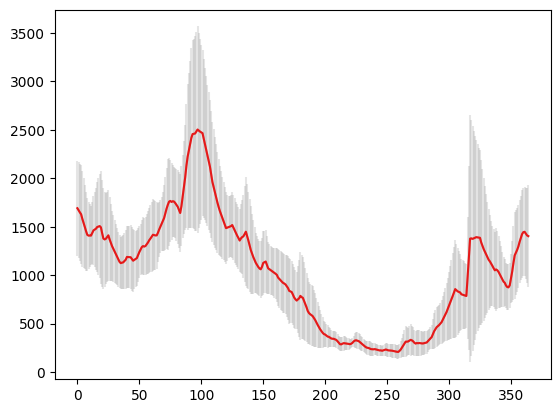

In [94]:
x = np.arange(0, 365, 1)
plt.errorbar(x, Q1_ave_baseflow, yerr=(Q1_min_baseflow, Q1_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q1_ave_baseflow, color='red')
# plt.errorbar(x, Q4_ave_baseflow, yerr=(Q4_min_baseflow, Q4_max_baseflow), color='gray', alpha = 0.2)
# plt.plot(x, Q4_ave_baseflow, color='red')

In [173]:
year_markers = [90, 91, 92, 92]
print(sum(year_markers))
def residual_dist(quartile):
    residuals = [[], [], [], []]
    for year_data in quartile:
        d = 0
        for i in range(len(year_markers)):
            for j in range(year_markers[i]):
                r = year_data[2][d] - year_data[3][d]
                if r > 0.0:
                    residuals[i].append(r)
                d += 1
    return residuals

def maxima_dist(quartile):
    maxima = [0, 0, 0, 0]
    for year_data in quartile:
        d = 0
        for i in range(len(year_markers)):
            for j in range(year_markers[i]):
                if d == 0 or d == 364:
                    d += 1
                    continue
                if year_data[2][d] >= year_data[2][d - 1] and year_data[2][d] >= year_data[2][d + 1]:
                    maxima[i] += 1
                d += 1
    return maxima

365


In [174]:
Q1_residuals = residual_dist(Q1)
Q4_residuals = residual_dist(Q4)

Q1_maxima_count = maxima_dist(Q1)
Q4_maxima_count = maxima_dist(Q4)

print(Q1_maxima_count, Q4_maxima_count)

[111, 105, 147, 118] [100, 98, 110, 94]


0.7055555555555556
0.7568681318681318
0.6875
0.720108695652174


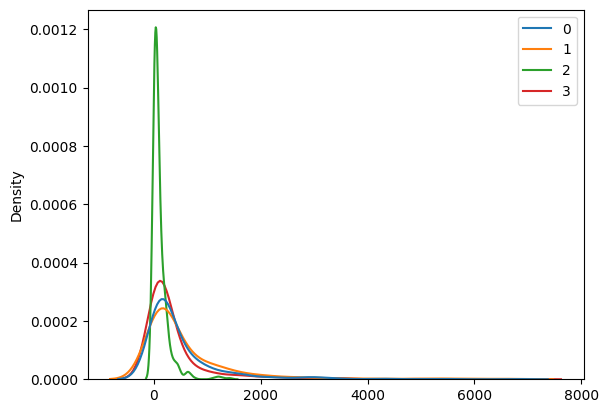

In [175]:
sns.kdeplot(Q1_residuals)
for q in range(len(Q1_residuals)):
    print(len(Q1_residuals[q]) / 8 / year_markers[q])

0.6875
0.6840659340659341
0.717391304347826
0.7771739130434783


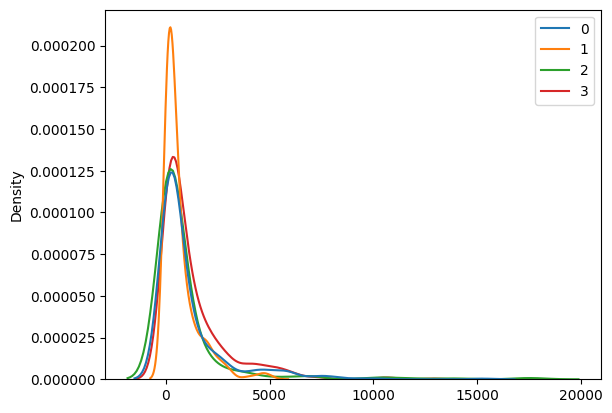

In [176]:
sns.kdeplot(Q4_residuals)
for q in range(len(Q4_residuals)):
    print(len(Q4_residuals[q]) / 8 / year_markers[q])

In [189]:
def timeseries(n, s):
    vals = list(np.random.normal(0.0, 0.25, n))
    s_half = s //  2

    # first pass
    mid_vals = []
    rolling_first = [vals[i - s_half] for i in range(n)]
    rolling = sum(rolling_first)
    for i in range(0, n):
        mid_vals.append(rolling / s)
        rolling += vals[(i + s_half + 2 * n) % n] - vals[(i - s_half + 2 * n) % n]
    fv_min = min(mid_vals)
    fv_max = max(mid_vals)
    fv_range = fv_max - fv_min
    for i in range(0, n):
        # final_vals[i] = final_vals[i]  / fv_max
        mid_vals[i] = ((mid_vals[i] - fv_min) / fv_range * 2) - 1.0

    # second pass
    final_vals = []
    rolling_second = [mid_vals[i - s_half] for i in range(n)]
    rolling = sum(rolling_second)
    for i in range(0, n):
        final_vals.append(rolling / s)
        rolling += mid_vals[(i + s_half + 2 * n) % n] - mid_vals[(i - s_half + 2 * n) % n]

    fv_min = min(final_vals)
    fv_max = max(final_vals)
    fv_range = fv_max - fv_min
    for i in range(0, n):
        final_vals[i] = (final_vals[i] - fv_min) / fv_range * 2.0 - 1.0

    return final_vals

# x = np.arange(0, 365, 1)
# ts = timeseries(365, 35)
# print(min(ts), max(ts))
# plt.plot(x, ts)

In [278]:
def gen_data(baseflow, min_flow, max_flow, event_count, noise):
    new_data = []
    d = 0
    ts = timeseries(365, 35)
    for i in range(len(year_markers)):
        for j in range(year_markers[i]):
            new_val = baseflow[d]
            if ts[d] < 0.0:
                new_val += min_flow[d] * ts[d]
            if ts[d] > 0.0:
                new_val += max_flow[d] * ts[d]
            if new_val < 0.0:
                new_val = 0.0
            new_data.append(new_val)
            d += 1
    # new_data = [0] * 365
    # add rain events
    d = 0
    for i in range(len(year_markers)):
        rain_prob = event_count[i] / 8 / year_markers[i]
        for j in range(year_markers[i]):
            r = random.random()
            if r < rain_prob:
                # rain event
                new_data[d] = new_data[d] + noise[i][random.randint(0, len(noise[i]) - 1)]

                # smooth dropoff from rain event
                rolling_window = sum(new_data[d:d+3])
                for k in range(2):
                    if d + 4 + k > 364:
                        break
                    new_data[d + k + 1] = rolling_window / 3
                    rolling_window += new_data[d + 3 + 1 + k] - new_data[d + k]
            d += 1


    return new_data


365078.1336910305 739534.4290269727


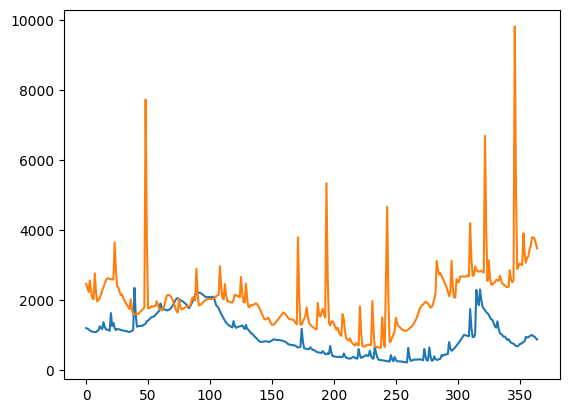

In [292]:
Q1_new = gen_data(Q1_ave_baseflow, Q1_min_baseflow, Q1_max_baseflow, Q1_maxima_count, Q1_residuals)
Q4_new = gen_data(Q4_ave_baseflow, Q4_min_baseflow, Q4_max_baseflow, Q4_maxima_count, Q4_residuals)
x = np.arange(0, 365, 1)
plt.plot(x, Q1_new)
plt.plot(x, Q4_new)
print(sum(Q1_new), sum(Q4_new))